In [1]:
import collections
import os.path as osp
import numpy as np
import numpy.linalg as npla
np.set_printoptions(6, suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'font.size': 7,
})

import utils

def rpy2rot(y, p, r):
    roll = lambda r: np.array([[1, 0, 0], [0, np.cos(r), np.sin(r)], [0, -np.sin(r), np.cos(r)]], dtype=np.float64)
    pitch = lambda p: np.array([[np.cos(p), 0, -np.sin(p)], [0, 1, 0], [np.sin(p), 0, np.cos(p)]], dtype=np.float64)
    yaw = lambda y: np.array([[np.cos(y), np.sin(y), 0], [-np.sin(y), np.cos(y), 0], [0, 0, 1]], dtype=np.float64)
    return roll(r) @ pitch(p) @ yaw(y)


def convert_line_to_pose(line):
    # returns T_iv
    line = line.replace('\n', ',').split(',')
    line = [float(i) for i in line[:-1]]
    # x, y, z -> 1, 2, 3
    # roll, pitch, yaw -> 7, 8, 9
    T = np.eye(4, dtype=np.float64)
    T[0, 3] = line[1]  # x
    T[1, 3] = line[2]  # y
    T[2, 3] = line[3]  # z
    T[:3, :3] = rpy2rot(line[9], line[8], line[7])

    return T


def load_pred_poses(filename):
    data = np.loadtxt(filename)
    poses = []
    for v in data:
        T_ms = np.eye(4)
        T_ms[:3, :] = v.reshape(3, 4)
        poses.append(T_ms)
    return np.array(poses)


def load_gt_poses(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    poses = []
    for line in lines[1:]:
        pose = convert_line_to_pose(line)
        poses.append(pose)

    T_s0_m = npla.inv(poses[0])
    poses = [T_s0_m @ T_ms for T_ms in poses]
    return np.array(poses)


def plot_pred_poses(ax, pred_poses, gt_poses, label, color):
    # T_gt_pred = utils.align_path(gt_poses, pred_poses)
    T_gt_pred = gt_poses[0] @ npla.inv(pred_poses[0])
    pred_poses = T_gt_pred @ pred_poses
    ax.plot(pred_poses[:, 0, 3] / 1e3, pred_poses[:, 1, 3] / 1e3, label=label, linewidth=1.0, color=color)
    max_x = np.max(pred_poses[:, 0, 3] / 1e3)
    min_x = np.min(pred_poses[:, 0, 3] / 1e3)
    max_y = np.max(pred_poses[:, 1, 3] / 1e3)
    min_y = np.min(pred_poses[:, 1, 3] / 1e3)
    mid_x = (max_x + min_x) / 2
    mid_y = (max_y + min_y) / 2
    range_x = max_x - min_x
    range_y = max_y - min_y
    longer = max(range_x, range_y)
    longer *= 1.1

    interval = 1
    left = ((mid_x - longer / 2) // interval) * interval
    right = ((mid_x + longer / 2) // interval + 1) * interval
    top = ((mid_y + longer / 2) // interval + 1) * interval
    bottom = ((mid_y - longer / 2) // interval) * interval
    ax.xaxis.set_ticks(np.arange(left, right, interval))
    ax.yaxis.set_ticks(np.arange(bottom, top, interval))

    ax.set_xlim(mid_x - longer / 2, mid_x + longer / 2)
    ax.set_ylim(mid_y - longer / 2, mid_y + longer / 2)


gt_path = '/home/yuchen/ASRL/data/boreas/sequences/'
pred_path = '/ext0/ASRL/steam_icp/results/boreas/'

In [2]:
### compute kitti metric
sequences = [
    'boreas-2022-08-05-12-59',  # h7
    'boreas-2022-08-05-13-30',  # h404
    'boreas-2022-08-05-13-54',  # dvp
    'boreas-2022-08-05-15-01',  # h427
]

local_kitti_errs = collections.defaultdict(list)
local_rpe_errs = collections.defaultdict(list)

print(f"                    KITTI metric:     t(2d)  r(2d)    t      r          RPE:     t(2d)    r(2d)      t      r")
for sequence in sequences:
  print(f"{sequence}:")
  gt_poses = load_gt_poses(osp.join(gt_path, sequence, 'applanix/aeva_poses.csv'))[60:]

  for pred_file in ["doppler_icp", "elastic_icp", "steam_icp", "steam_dicp"]:
    ##
    pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence + '_poses.txt'))[60:]
    # kitti metric
    t_err_2d, r_err_2d, t_err, r_err, err_3d = utils.evaluate_odometry_kitti(gt_poses, pred_poses)
    print(f"  {pred_file:<35} & {t_err_2d:.2f} & {r_err_2d:.4f} & {t_err:.2f} & {r_err:.4f}", end='')
    local_kitti_errs[pred_file].append(err_3d)
    # rpe metric
    t_err_2d, r_err_2d, t_err, r_err, pose_errors = utils.evaluate_odometry_rpe(gt_poses, pred_poses)
    print(f"            & {t_err_2d:.4f} & {r_err_2d:.4f} & {t_err:.4f} & {r_err:.4f} \\\\")
    local_rpe_errs[pred_file].extend(pose_errors)

print("average: ")
for pred_file in local_kitti_errs.keys():
  errs = local_kitti_errs[pred_file]
  t_err, r_err = utils.get_avg_stats(errs)
  print(f"{pred_file:<35} & {0.0:.2f} & {0.0:.4f} & {t_err:.2f} & {r_err:.4f}", end='')

  errs = local_rpe_errs[pred_file]
  t_err, r_err = utils.get_avg_rpe(errs)
  print(f"            & {0.0:.4f} & {0.0:.4f} & {t_err:.4f} & {r_err:.4f} \\\\")

                    KITTI metric:     t(2d)  r(2d)    t      r          RPE:     t(2d)    r(2d)      t      r
boreas-2022-08-05-12-59:
  doppler_icp                         & 3.82 & 0.0098 & 6.26 & 0.0155            & 0.0865 & 0.0179 & 0.1033 & 0.0968 \\
  elastic_icp                         & 0.41 & 0.0007 & 2.81 & 0.0058            & 0.0188 & 0.0216 & 0.0586 & 0.1081 \\
  steam_icp                           & 0.46 & 0.0008 & 2.84 & 0.0058            & 0.0208 & 0.0225 & 0.0592 & 0.1059 \\
  steam_dicp                          & 0.40 & 0.0005 & 2.82 & 0.0057            & 0.0064 & 0.0204 & 0.0558 & 0.1052 \\
boreas-2022-08-05-13-30:
  doppler_icp                         & 0.84 & 0.0024 & 4.01 & 0.0124            & 0.0472 & 0.0112 & 0.0832 & 0.0710 \\
  elastic_icp                         & 0.36 & 0.0008 & 3.03 & 0.0054            & 0.0194 & 0.0206 & 0.0697 & 0.0838 \\
  steam_icp                           & 0.32 & 0.0006 & 3.02 & 0.0054            & 0.0248 & 0.0221 & 0.0714 & 0.0832 \\


In [3]:
### compute kitti metric
sequences = [
    'boreas-2022-08-05-12-59',  # h7
    'boreas-2022-08-05-13-30',  # h404
    'boreas-2022-08-05-13-54',  # dvp
    'boreas-2022-08-05-15-01',  # h427
]

local_kitti_errs = collections.defaultdict(list)
local_rpe_errs = collections.defaultdict(list)

print(f"                    KITTI metric:     t(2d)  r(2d)    t      r          RPE:     t(2d)    r(2d)      t      r")
for sequence in sequences:
  print(f"{sequence}:")
  gt_poses = load_gt_poses(osp.join(gt_path, sequence, 'applanix/aeva_poses.csv'))[60:]

  for pred_file in ["doppler_icp_40m", "elastic_icp_40m", "steam_icp_40m", "steam_dicp_40m"]:
    #
    pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence+'_poses.txt'))[60:]
    # kitti metric
    t_err_2d, r_err_2d, t_err, r_err, err_3d = utils.evaluate_odometry_kitti(gt_poses, pred_poses)
    print(f"  {pred_file:<35} & {t_err_2d:.2f} & {r_err_2d:.4f} & {t_err:.2f} & {r_err:.4f}", end = '')
    local_kitti_errs[pred_file].append(err_3d)
    # rpe metric
    t_err_2d, r_err_2d, t_err, r_err, pose_errors = utils.evaluate_odometry_rpe(gt_poses, pred_poses)
    print(f"            & {t_err_2d:.4f} & {r_err_2d:.4f} & {t_err:.4f} & {r_err:.4f} \\\\")
    local_rpe_errs[pred_file].extend(pose_errors)

print("average: ")
for pred_file in local_kitti_errs.keys():
  errs = local_kitti_errs[pred_file]
  t_err, r_err = utils.get_avg_stats(errs)
  print(f"{pred_file:<35} & {0.0:.2f} & {0.0:.4f} & {t_err:.2f} & {r_err:.4f}", end = '')

  errs = local_rpe_errs[pred_file]
  t_err, r_err = utils.get_avg_rpe(errs)
  print(f"            & {0.0:.4f} & {0.0:.4f} & {t_err:.4f} & {r_err:.4f} \\\\")

                    KITTI metric:     t(2d)  r(2d)    t      r          RPE:     t(2d)    r(2d)      t      r
boreas-2022-08-05-12-59:
  doppler_icp_40m                     & 13.64 & 0.0331 & 15.53 & 0.0386            & 0.2582 & 0.0609 & 0.2643 & 0.1439 \\
  elastic_icp_40m                     & 10.60 & 0.0306 & 12.24 & 0.0338            & 0.0849 & 0.1099 & 0.1020 & 0.1770 \\
  steam_icp_40m                       & 67.38 & 0.1215 & 68.30 & 0.1239            & 1.6018 & 0.7957 & 1.6031 & 0.8504 \\
  steam_dicp_40m                      & 1.81 & 0.0047 & 3.89 & 0.0094            & 0.0168 & 0.0739 & 0.0581 & 0.1442 \\
boreas-2022-08-05-13-30:
  doppler_icp_40m                     & 3.42 & 0.0071 & 7.35 & 0.0239            & 0.1672 & 0.0273 & 0.1813 & 0.1039 \\
  elastic_icp_40m                     & 53.17 & 0.0497 & 56.98 & 0.2092            & 1.8999 & 4.6168 & 1.9124 & 71.1786 \\
  steam_icp_40m                       & 2.93 & 0.0070 & 5.23 & 0.0105            & 0.1101 & 0.0862 & 0.1281 & 0

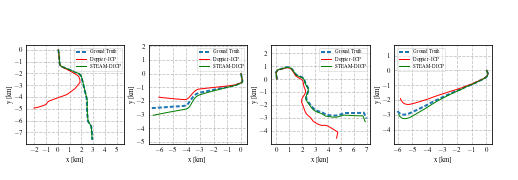

In [4]:
sequences = [
    'boreas-2022-08-05-12-59',  # h7
    'boreas-2022-08-05-13-30',  # h404
    'boreas-2022-08-05-13-54',  # dvp
    'boreas-2022-08-05-15-01',  # h427
]

fig, axs = plt.subplots(1, len(sequences), figsize=(7.2, 2.5))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.0, top=0.95, wspace=0.25, hspace=0.25)

for i, sequence in enumerate(sequences):
  ax = axs[i]

  gt_poses = load_gt_poses(osp.join(gt_path, sequence, 'applanix/aeva_poses.csv'))[60:]
  ax.plot(gt_poses[:, 0, 3] / 1e3, gt_poses[:, 1, 3] / 1e3, "--", label='Ground Truth', linewidth=2.0, dashes=(2, 1))

  pred_file = 'doppler_icp'
  pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence+'_poses.txt'))[60:]
  plot_pred_poses(ax, pred_poses, gt_poses, 'Doppler-ICP', 'red')

  pred_file = 'steam_dicp'
  pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence+'_poses.txt'))[60:]
  plot_pred_poses(ax, pred_poses, gt_poses, 'STEAM-DICP', 'green')

  ax.set_xlabel('x [km]')
  ax.set_ylabel('y [km]', labelpad=1)
  ax.grid(which='both', linestyle='--', alpha=0.75)
  ax.set_aspect('equal', 'box')
  ax.legend(framealpha=0.5, fontsize=5)
  ax.tick_params(axis=u'both', which=u'both',length=0)

# plt.savefig('/home/yuchen/ASRL/notes/2023-icra-wu/figs/boreas_qualitative.pdf', format="pdf", bbox_inches="tight")
plt.show()